This ipynb will perform fits of several spherically symmetric density profiles. 

In [6]:
#imports
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy import units
import getdata
import densities
from scipy.optimize import curve_fit

In [43]:
#density calculation and plotting functions
def getdensityprofile(nr_bins = 1000, bin_distr = "adaptive"):
    bin_distr_options = ["linear", "logarithmic", "adaptive"]
    coords = getdata.coordskpc()
    mass = getdata.masssolar()
    
    if(bin_distr not in bin_distr_options):
        print(f"Error: bin_distr contains no valid distribution type. Choose from: " + str(bin_distr_options) + ", performing linear distribution instead.")
        bin_distr = "linear"

    if((nr_bins <= 1) or (isinstance(nr_bins, int) == False)):
        print(f"Error: bin amount must be a positive integer. Will now default to 1000 bins.")
        nr_bins = 1000

    coord_com = np.sum(coords,axis=0) / len(coords)
    coords_centred = coords - coord_com
    com_dist = np.sqrt(np.sum(coords_centred**2, axis=1))

    r_min = np.min(com_dist)
    r_max = np.max(com_dist)
    bins = np.linspace(r_min, r_max, nr_bins) 
    
    if(bin_distr == "adaptive"):
        com_dist_sorted = np.sort(com_dist)
        nr_particles = len(com_dist_sorted)

        bin_size = nr_particles // nr_bins
        bin_limit = nr_bins*bin_size
        bins = com_dist_sorted[:bin_limit].reshape(nr_bins, bin_size)

        bin_inner_bound = bins[:, 0]         
        bin_outer_bound = bins[:, -1]       
        bin_centre = np.mean(bins, axis=1)  

        bin_volume = (4/3)*np.pi*(bin_outer_bound**3 - bin_inner_bound**3)
        bin_density = bin_size*mass / bin_volume
        bin_poisson_error = np.sqrt(bin_size)*mass / bin_volume
        return bin_centre, bin_density, bin_poisson_error
        
    if(bin_distr == "linear"):
        bins = np.linspace(r_min, r_max, nr_bins)
    if(bin_distr == "logarithmic"):
        bins = np.logspace(np.log10(r_min.value), np.log10(r_max.value), nr_bins) * r_min.unit
    
    bin_counts, bin_edges = np.histogram(com_dist, bins=bins)
    bin_inner_bound = bin_edges[:-1]
    bin_outer_bound = bin_edges[1:]
    bin_centre = (bin_outer_bound + bin_inner_bound) / 2
    
    bin_volume = (4/3)*np.pi*(bin_outer_bound**3 - bin_inner_bound**3)
    bin_density = bin_counts*mass / bin_volume
    bin_poisson_error = np.sqrt(bin_counts)*mass / bin_volume

    return bin_centre, bin_density, bin_poisson_error

def plotdensityfunction(title = "untitled_denistyplot", nr_bins = 1000, bin_distr = "adaptive", plot_scale = "logarithmic"):
    bin_centre, bin_density, bin_poisson_error = getdensityprofile(nr_bins=nr_bins, bin_distr=bin_distr)

    plot_scale_options = ["linear", "logarithmic", "both"]
    if(plot_scale not in plot_scale_options):
        print(f"Error: wrong scaling option entered. Choose from the following: " + str(plot_scale_options) + str("/nplotting in logarithmic scale instead."))
        plot_scale = "logarithmic"

    plt.xlabel("Radius (" + str(bin_centre.unit) + ")")
    plt.ylabel("Density (" + str(bin_density.unit) + ")")
    if(plot_scale != "both"):
        plt.scatter(bin_centre, bin_density, s=1)
        plt.errorbar(bin_centre, bin_density, yerr=bin_poisson_error, capsize=1, fmt='none', alpha=0.0)

        if(plot_scale == "logarithmic"):
            plt.xscale("log")
            plt.yscale("log")
        if(plot_scale == "linear"):
            plt.xscale("linear")
            plt.yscale("linear")
            
        plt.show()

    if(plot_scale == "both"):
        plt.subplot(2, 1, 1)
        plt.scatter(bin_centre, bin_density, s=1)
        plt.errorbar(bin_centre, bin_density, yerr=bin_poisson_error, capsize=1, fmt='none', alpha=0.0)
        plt.xscale("log")
        plt.yscale("log")
        
        plt.subplot(2, 1, 2)
        plt.scatter(bin_centre, bin_density, s=1)
        plt.errorbar(bin_centre, bin_density, yerr=bin_poisson_error, capsize=1, fmt='none', alpha=0.0)
        plt.xscale("linear")
        plt.yscale("linear")
        plt.show()

In [54]:
#density fitting calculation
def getdensityfit(potential = "hernquist", nr_bins = 100, bin_distr = "adaptive"):
    potential_options = ["hernquist", "plummer", "doublepowerlaw"]
    if potential is None:
        return potential_options
    if(potential not in potential_options):
        print(f"Error: Unimplemented potential given. Choose from: " + str(potential_options) + ", performing hernquist fit instead.")
        potential = "hernquist"
    
    total_mass = getdata.masssolar() * len(getdata.coordskpc())
    bcentre, bdensity, bpoissonerror = getdensityprofile(nr_bins = nr_bins, bin_distr = bin_distr)
    popt = []
    pcov = []
    param = []
    param_error = []

    if(potential == "hernquist"):
        popt, pcov = curve_fit(
        densities.hernquist,
        bcentre.value,
        bdensity.value,
        p0=[total_mass.value, 100]                                       #guess that mass is total mass in solarmasses and that b is 100 kpc     
        )
        
        mass_solfit, b_kpcfit = popt
        mass_solfit = mass_solfit * total_mass.unit
        b_kpcfit = b_kpcfit * bcentre.unit
        param = [mass_solfit, b_kpcfit]

    if(potential == "plummer"):
        popt, pcov = curve_fit(
        densities.plummer,
        bcentre.value,
        bdensity.value,
        p0=[total_mass.value, 100]                                           
        )
        
        mass_solfit, b_kpcfit = popt
        mass_solfit = mass_solfit * total_mass.unit
        b_kpcfit = b_kpcfit * bcentre.unit
        param = [mass_solfit, b_kpcfit]

    if(potential == "doublepowerlaw"):
        popt, pcov = curve_fit(
        densities.doublepowerlaw,
        bcentre.value,
        bdensity.value,
        p0=[total_mass.value, 100, 0.5, 1.0]                                           
        )
        
        mass_solfit, b_kpcfit, alpha, beta = popt
        mass_solfit = mass_solfit * total_mass.unit
        b_kpcfit = b_kpcfit * bcentre.unit
        param = [mass_solfit, b_kpcfit, alpha, beta]
    
    function = getattr(densities, potential)                             #if given string of function located in python file densities, gives function.
    param_error = np.sqrt(np.diag(pcov))
    
    residuals = bdensity.value - function(bcentre.value, *popt)          #popt instead of param because of units
    rms_error = np.sqrt(np.mean(residuals**2))                           #absolute error
    
    squaresum_residual = np.sum(residuals**2)
    squaresum_total = np.sum((bdensity.value - np.mean(bdensity.value))**2)
    rsquared_error = 1.0 - (squaresum_residual / squaresum_total)        #relative error

    print("optimal parameters for " + potential + ": " + str(param))
    print("STD of the parameters: " + str(param_error))
    print("RMSE of " + potential + " fit: " + str(rms_error))
    print("RSQUARED of " + potential + " fit: " + str(rsquared_error))   #RSQUARED of 1 is best.
    
    return param, param_error, rms_error, rsquared_error, potential, bcentre, bdensity

In [164]:
#density fit plotting
def plotdensityfit(potential = "hernquist", nr_bins = 100, bin_distr = "adaptive"):
    if potential is None:
        print(f"Error: Unimplemented potential given. Choose from: " + getdensityfit(potential=None) + ", performing hernquist fit instead.")
        potential = "hernquist"

    param, param_error, rms_error, rsquared_error, potential, bcentre, bdensity = getdensityfit(potential=potential, nr_bins=nr_bins, bin_distr=bin_distr)
    function = getattr(densities, potential)

    fig, axs = plt.subplots(2, sharex=False, sharey=False)
    fig.suptitle(potential + " density profile fit")
    axs[0].scatter(bcentre, bdensity, s=1, label="data")
    axs[0].plot(bcentre, function(bcentre, *param), c="red", label="fit")
    axs[0].set_xscale("log")
    axs[0].set_yscale("log")
    
    axs[1].scatter(bcentre, bdensity, s=1, label="data")
    axs[1].plot(bcentre, function(bcentre, *param), c="red", label="fit")
    axs[1].set_xscale("linear")
    axs[1].set_yscale("linear")

    fig.supxlabel("Radius (" + str(bcentre.unit) + ")") 
    fig.supylabel("Density (" + str(bdensity.unit) + ")") 
    axs[0].text(0.98, 0.9, r"$R^2$ = " + ("%.3f" % rsquared_error), transform=axs[0].transAxes,
            va="top", ha="right", fontsize=9, color="black")
    
    #plt.supxlabel("Radius (" + str(bcentre.unit) + ")")
    #plt.supylabel("Density (" + str(bdensity.unit) + ")")
    #plt.suptitle(potential + " fit of the density profile")
    plt.legend()
    plt.tight_layout()
    plt.show()
    

optimal parameters for doublepowerlaw: [<Quantity 1.24581549e+09 solMass>, <Quantity 0.65655884 kpc>, np.float64(-0.029081112742790283), np.float64(1.744667393898312)]
STD of the parameters: [6.43728383e+07 1.62745491e-02 2.83675336e-02 1.03713380e-02]
RMSE of doublepowerlaw fit: 603689.3634133526
RSQUARED of doublepowerlaw fit: 0.9982341578720705


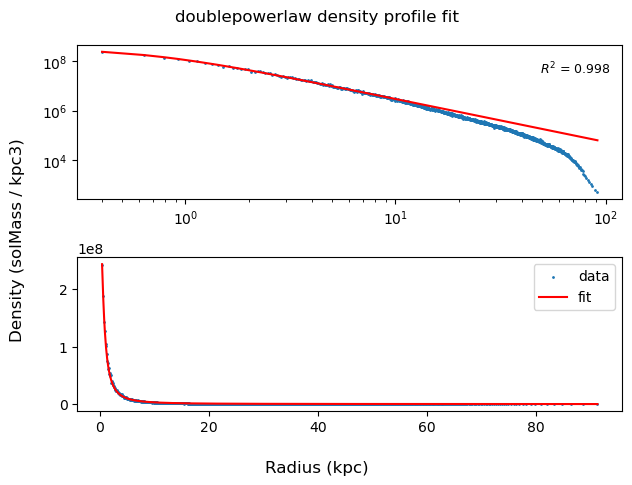

In [165]:
plotdensityfit(potential = "doublepowerlaw", nr_bins=1000, bin_distr="adaptive")

optimal parameters for hernquist: [<Quantity 7.41073832e+08 solMass>, <Quantity 18.33245169 kpc>]
STD of the parameters: [3.80535081e+06 3.97880582e-01]
RMSE of hernquist fit: 1606764.694074368
RSQUARED of hernquist fit: 0.987490804317522


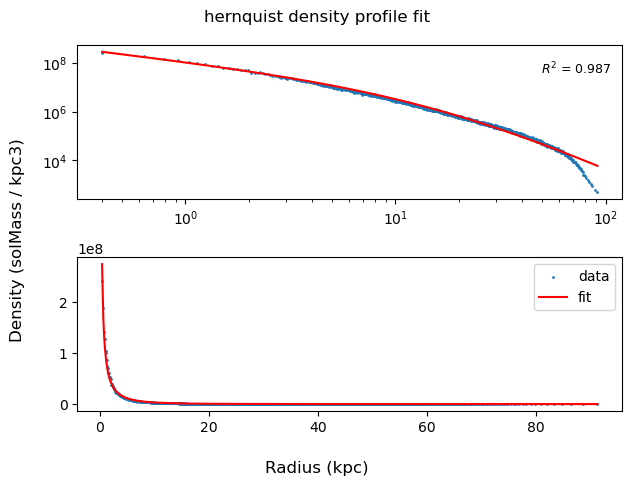

In [166]:
plotdensityfit(potential = "hernquist", nr_bins=1000, bin_distr="adaptive")

optimal parameters for plummer: [<Quantity 8.59306208e+09 solMass>, <Quantity 2.11566741 kpc>]
STD of the parameters: [1.90387145e+08 2.17112264e-02]
RMSE of plummer fit: 3472964.7868492384
RSQUARED of plummer fit: 0.9415579306107779


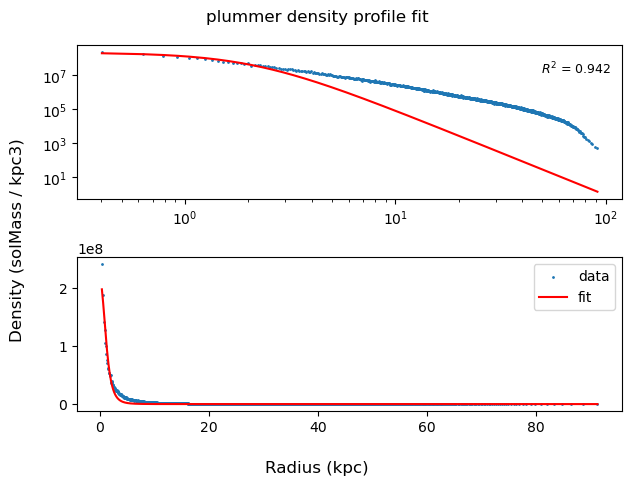

In [167]:
plotdensityfit(potential = "plummer", nr_bins=1000, bin_distr="adaptive")